In [2]:
"""A simple MDL calculator using the Map Equation and a graph."""
import networkx as nx
from math import log
import numpy as np
import argparse

import sys

TAU       = 0.1
PAGE_RANK = 'page_rank'
MODULE_ID = 'module_id'

In [3]:

def log2(prob):
    "Returns the log of prob in base 2"
    return log(prob, 2)

def entropy1(prob):
    """Half of the entropy function, as used in the InfoMap paper.
    entropy1(p) = p * log2(p)
    """
    if prob == 0:
        return 0
    return prob * log2(prob)


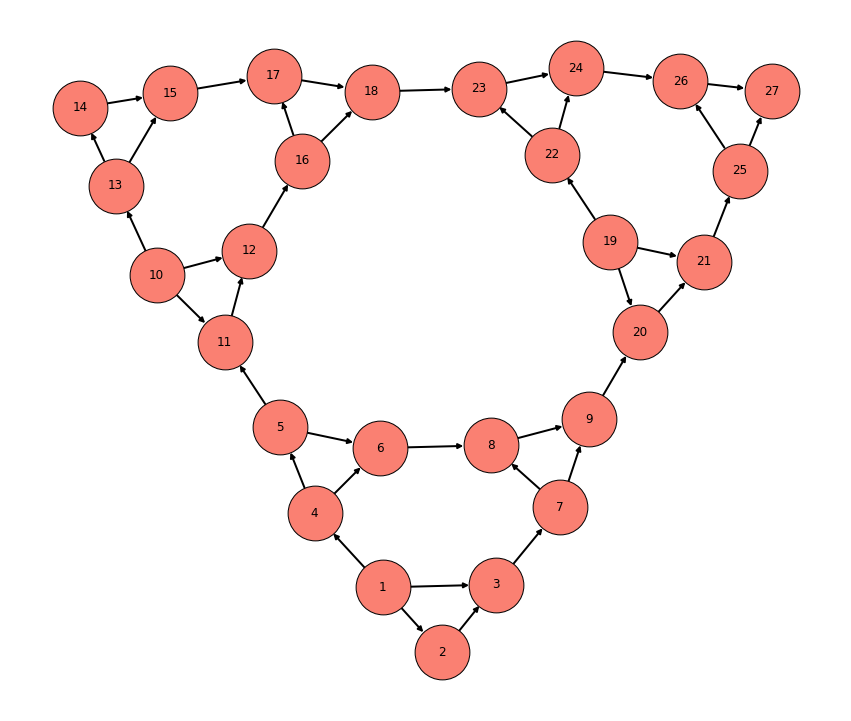

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

nodes = ["1" ,"2" ,"3" ,"4" ,"5" ,"6" ,"7" ,"8" ,"9" ,"10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19" ,"20" ,"21" ,"22" ,"23" ,"24" ,"25" ,"26" ,"27"]
edges = [(1, 2),(1, 3),(1, 4),(2, 3),(3, 7),(4, 5),(4, 6),(5, 6),(6, 8),(7, 8),(7, 9),(8, 9),(10, 11),(10, 12),(10, 13),(11, 12), (12, 16), (13, 14), (13, 15), (14, 15),(15, 17),(16, 17),(16, 18),(17, 18),(19, 20),(19, 21),(19, 22),(20, 21),(21, 25),(22, 23),(22, 24),(23, 24),(24, 26),(25, 26),(25, 27),(26, 27),(9, 20),(5, 11),(18, 23)]

g      = nx.DiGraph((x, y, {'weight': 1}) for (x, y), v in Counter(edges).items())
layout = nx.nx_agraph.pygraphviz_layout(g)

fig, ax = plt.subplots(1, 1, figsize=(15, 13))
nx.draw(ax=ax, G=g, pos=layout, node_size=3000, node_color="salmon", edgecolors="k", width=2, with_labels=True)

graph = g

In [5]:
def log2(prob):
    "Returns the log of prob in base 2"
    return log(prob, 2)

def entropy1(prob):
    """Half of the entropy function, as used in the InfoMap paper.
    entropy1(p) = p * log2(p)
    """
    if prob == 0:
        return 0
    return prob * log2(prob)

#modules = [Module(module_id, module, graph) for (module_id, module) in enumerate(single_nodes)]
def compute_module_properties(modules_list, network):
    modules = []
    graph   = network
    # loop through modules and compute stuff
    for (module_id, nodes) in enumerate(modules_list):

        module_id = module_id
        nodes     = frozenset(nodes)
        graph     = graph
        prop_nodes = 1 - float( len(nodes)) / len(graph)

        # Set the module_id for every node
        for node in nodes:
            graph.nodes[int(node)][MODULE_ID] = module_id

        total_pr = sum([graph.nodes[int(node)][PAGE_RANK] for node in nodes])

        # Exit probability of this module
        # .. Left half: tau * (n - n_i) / n * sum{alpha in i}(p_alpha)

        q_out = total_pr * TAU * prop_nodes

        # .. Right half: (1-tau) * sum{alpha in i}(sum{beta not in i}
        #                  p_alpha weight_alpha,beta)
        # This is what's in [RAB2009 eq. 6]. But it's apparently wrong if node alpha has no out-edges, which is not in the paper.

        for node in nodes:
            edges = graph.edges(node, data=True)
            page_rank = graph.nodes[int(node)][PAGE_RANK]
            if len(edges) == 0:
                q_out += page_rank * prop_nodes * (1 - TAU)
                continue

            for (_, dest, data) in edges:
                if dest not in nodes:
                    q_out += page_rank * data['weight'] * (1 - TAU)

        q_plus_p = q_out + total_pr
        module_dict = {}
        module_dict["prop_nodes"]  = prop_nodes
        module_dict["module_id"]   = module_id
        module_dict["total_pr"]    = total_pr
        module_dict["q_plus_p"]    = q_plus_p
        module_dict["nodes"]       = frozenset(nodes)
        module_dict["graph"]       = graph             # store graph with defined module id
        module_dict["q_out"]       = q_out

        # compute codebook length
        first  = -entropy1(q_out / q_plus_p)
        second = -sum( [entropy1(module_dict["graph"].nodes[int(node)][PAGE_RANK]/module_dict["q_plus_p"]) for node in module_dict["nodes"]])

        module_dict["codebook_length"] = q_plus_p * (first + second)
        modules.append(module_dict)

    return modules


def get_mdl(modules, total_pr_entropy):
    "Compute the MDL of this clustering according to [RAB2009, eq. 4]"
     # the map equation
    total_qout = 0
    total_qout_entropy = 0
    total_both_entropy = 0
    for mod in modules:
        q_out              = mod["q_out"]
        total_qout         += q_out
        total_qout_entropy += entropy1(q_out)
        total_both_entropy += entropy1(mod["q_plus_p"])

    term1 = entropy1(total_qout)
    term2 = -2 * total_qout_entropy
    term3 = -total_pr_entropy
    term4 = total_both_entropy
    return term1 + term2 + term3 + term4

def get_index_codelength(modules):
    "Compute the index codebook length according to [RAB2009, eq. 2]"
    if len(modules) == 1:
        return 0
    total_q = sum([mod["q_out"] for mod in modules])
    if total_q==0:
        return 0
    entropy = -sum([entropy1(mod["q_out"] / total_q) for mod in modules])
    return total_q * entropy


In [6]:
from operator import itemgetter
import itertools

def modules_proposal(modules, edges_list):
    """_summary_

    Args:
        modules    : list with the current modules. [[node_1i_module_i, node2i_module_i], ..., [node_1n_module_n, node2n_module_n]]
        edges_list : List with the original edges in the network (node_i, node_j)
    """

    edges_list = [[node1, node2] for node1, node2 in edges_list]
    edges_list = np.array(edges_list)

    # store new possible modules
    new_modules  = []

    for idx_module, nodes_module in enumerate(modules):
        # idx_module      = 0
        # nodes_module    = modules[idx_module]

        merge1          = edges_list[np.isin(edges_list[:,0], nodes_module),:][:,1]
        merge2          = edges_list[np.isin(edges_list[:,1], nodes_module),:][:,0]

        possible_nodes  = list(set(list(np.concatenate([merge1, merge2]))) - set(nodes_module))
        modules_add     = [ nodes_module + [node_new]    for node_new in possible_nodes]
        module_possible = [ add_module(mod, modules) for mod in modules_add]
        new_modules.extend(module_possible)

    new_modules.sort()
    new_modules = list(k for k,_ in itertools.groupby(new_modules))

    return new_modules

def add_module(new_module, past_modules):
    """ This function receive a new set of nodes 'new_module' and all the past modules 'past_modules'.

    Args:
        new_module   : list with new module nodes [node_1, node_2, node_3, ..., node_n]
        past_modules :list with pasts modules nodes [module_1, module_2, module_3, ..., module_n]
    """

    modules_new  = []

    for module in past_modules:
        if np.isin(new_module, module).any():
            modules_new.append(list(set(new_module+module)))
        else:
            modules_new.append(module)

    modules_new.sort()
    modules_new = list(k for k,_ in itertools.groupby(modules_new))

    return modules_new

def return_best_module(possible_modules, map_eq_best=30, total_pr_entropy=0):

    # by default last best modules where the first ones.
    for idx_module, possible_module in enumerate(possible_modules):

        dict_this  = compute_module_properties(possible_module, graph)
        map_eq         = get_mdl(dict_this, total_pr_entropy)

        if map_eq < map_eq_best:
            map_eq_best = map_eq
            idx_best    = idx_module
            best_module =  possible_modules[idx_best]
        else:
            idx_best = 0
            best_module = possible_modules[0]

    return best_module, map_eq_best, idx_best


In [7]:

for node in graph:

    edges = graph.edges(node, data=True)
    total_weight = sum([data['weight'] for (_, _, data) in edges])

    for (_, _, data) in edges:
        data['weight'] = data['weight'] / total_weight

# Get its PageRank, alpha is 1-tau where [RAB2009 says \tau=0.15]
page_ranks = nx.pagerank(graph, alpha=1-TAU)
for (node, page_rank) in page_ranks.items():
    graph.nodes[node][PAGE_RANK] = page_rank


total_pr_entropy = sum([entropy1(graph.nodes[node][PAGE_RANK]) for node in graph])

modules        = [[nodes] for nodes in graph]
modules_dicts  = compute_module_properties(modules, graph)
map_eq_best    = get_mdl(modules_dicts, total_pr_entropy)

num_iters = 0
while True:
    print(num_iters)
    new_modules                 = modules_proposal(modules, list(graph.edges()))

    # add previous module to possible set of new modules
    new_modules                 = [modules] + new_modules
    modules, map_eq, idx_module = return_best_module(new_modules, map_eq_best=map_eq_best, total_pr_entropy=total_pr_entropy)
    num_iters += 1

    print(map_eq)
    if map_eq<map_eq_best:
        map_eq_best =map_eq
    else:
        break


0
6.012347428900845
1
6.012347428900845


In [23]:
map_eq_bestttt = 10

idxxx = 0
while 1:
    print(idxxx)

    new_modules                 = modules_proposal(modules, list(graph.edges()))

    map_eq_values = []
    for idx_mod in range(len(new_modules)):

        modules_dicts  = compute_module_properties(new_modules[idx_mod], graph)
        map_eq         = get_mdl(modules_dicts, total_pr_entropy)
        map_eq_values.append(map_eq)

    modules     = new_modules[np.argmin(map_eq_values)]
    map_eq_best = map_eq_values[np.argmin(map_eq_values)]
    idxxx += 1

    if map_eq_best<map_eq_bestttt:
        map_eq_bestttt = map_eq_best
    else:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [24]:
map_eq_bestttt

4.332318941039624

In [25]:
modules

[[1, 2, 3, 7],
 [4, 5, 6],
 [4, 5, 6, 8, 9, 20],
 [13, 14, 15],
 [16, 10, 11, 12],
 [17, 18, 22, 23, 24],
 [25, 19, 21],
 [26, 27]]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

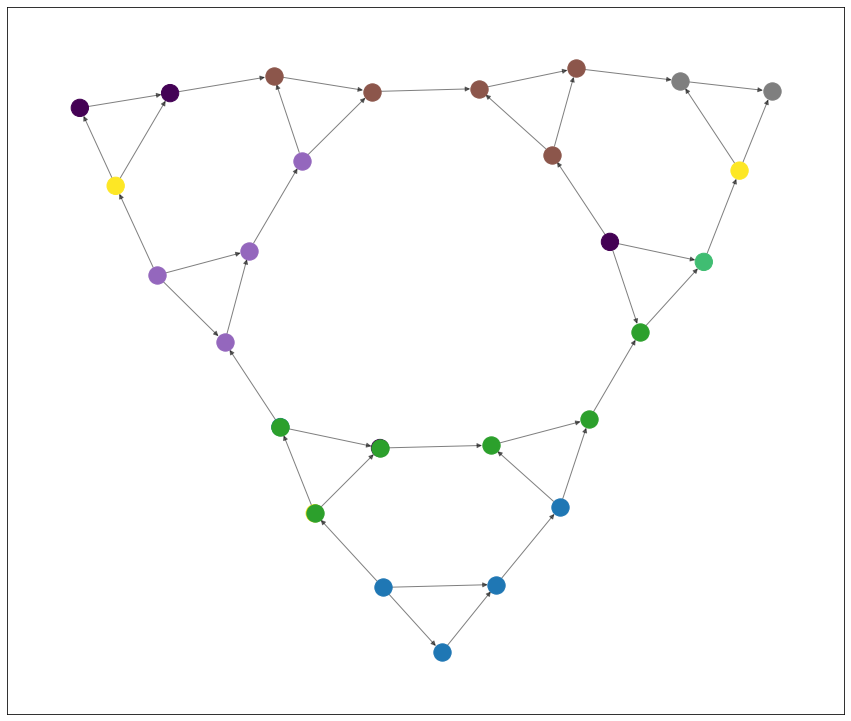

In [26]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

nodes = ["1" ,"2" ,"3" ,"4" ,"5" ,"6" ,"7" ,"8" ,"9" ,"10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19" ,"20" ,"21" ,"22" ,"23" ,"24" ,"25" ,"26" ,"27"]
edges = [(1, 2),(1, 3),(1, 4),(2, 3),(3, 7),(4, 5),(4, 6),(5, 6),(6, 8),(7, 8),(7, 9),(8, 9),(10, 11),(10, 12),(10, 13),(11, 12), (12, 16), (13, 14), (13, 15), (14, 15),(15, 17),(16, 17),(16, 18),(17, 18),(19, 20),(19, 21),(19, 22),(20, 21),(21, 25),(22, 23),(22, 24),(23, 24),(24, 26),(25, 26),(25, 27),(26, 27),(9, 20),(5, 11),(18, 23)]


palettes = sns.color_palette("tab10")

g      = nx.DiGraph((x, y, {'weight': 1}) for (x, y), v in Counter(edges).items())
layout = nx.nx_agraph.pygraphviz_layout(g)

fig, ax = plt.subplots(1, 1, figsize=(15, 13))

for idx_mod, mod in enumerate(modules):
    nx.draw_networkx_nodes(g, layout, nodelist=mod, node_color=palettes[idx_mod])#, with_labels=True)

nx.draw_networkx_edges(g, layout, width=1.0, alpha=0.5)

